In [1]:
from dataset import *
from helpers.ipython import *
from helpers.model import *
%matplotlib inline

y = data.get('train', 'y')

# Dota 2: Win Probability Prediction

https://inclass.kaggle.com/c/dota-2-win-probability-prediction

У вас есть обучающая выборка матчей, для которых известны все события матча и его результат. В тестовой выборке матчей история обрезана на первых 5 минутах, вам необходимо предсказать для тестовых матчей вероятность победы Radiant.

Качество прогноза будет оцениваться на тестовом тестовом множестве матчей. В качестве метрики качества — AUC-ROC.

# Исходные фичи

In [2]:
data.load(13)

def hist_by_radiant_win(df, field, bins=50):
    groups = df.groupby('radiant_win')[field]
    fig, ax = plt.subplots()
    for k, v in reversed(list(groups)):
        v.hist(label=str(k), alpha=.75, ax=ax, bins=bins)

    ax.legend(title='radiant_win')

## Матч

In [123]:
df = pd.concat([y, data.get('train', 'match')], axis=1)

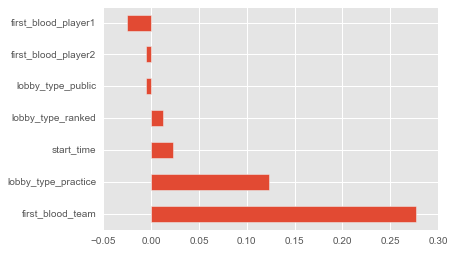

In [28]:
model_lr_explore_l1(pd.concat([data.get('train', 'match'), data.get('train', 'fb')], axis=1), y).plot.barh()

Событие "Первая кровь" положительно влияет на шанс победы, оно и не удивительно. А вот большое влияние времени и типа комнаты "Практика" тяжело объяснить.

### Время

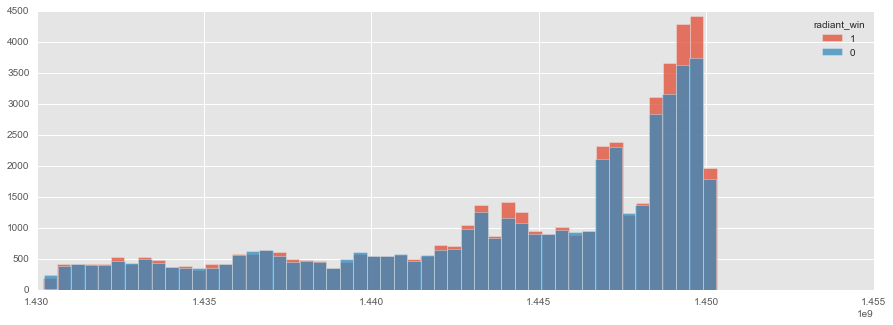

In [124]:
hist_by_radiant_win(df, 'start_time')

Действительно, есть периоды времени, в которые Radiant выигрывает заметно чаще.

### Тип комнаты

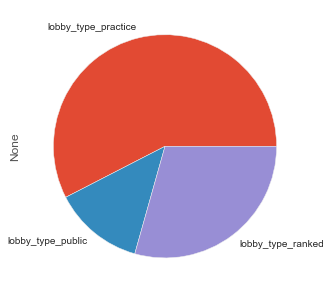

In [40]:
lobbies = ['lobby_type_practice', 'lobby_type_public', 'lobby_type_ranked']
df[lobbies].sum().plot.pie(figsize=(5,5))

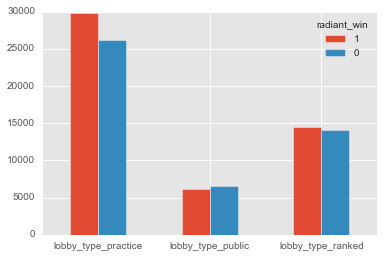

In [43]:
df.groupby('radiant_win')[lobbies].sum().iloc[::-1].T.plot.bar(rot=0)

В типе комнаты "Практика" Radiant выигрывает чаще, это мы видели и выше.

### Событие "Первая кровь"

In [45]:
df = pd.concat([y, data.get('train', 'fb')], axis=1)

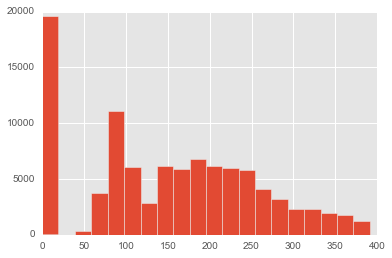

In [49]:
df['first_blood_time'].hist(bins=20)

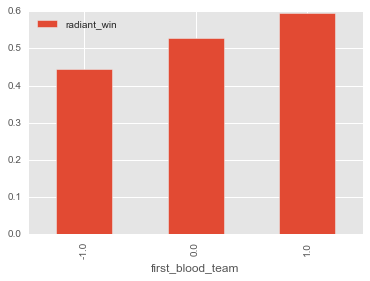

In [58]:
df.groupby('first_blood_team')[['radiant_win']].mean().plot.bar()

Команда, совершившая "Первую кровь" имеет большие шансы на победу (примерно на 5%).

## Игроки

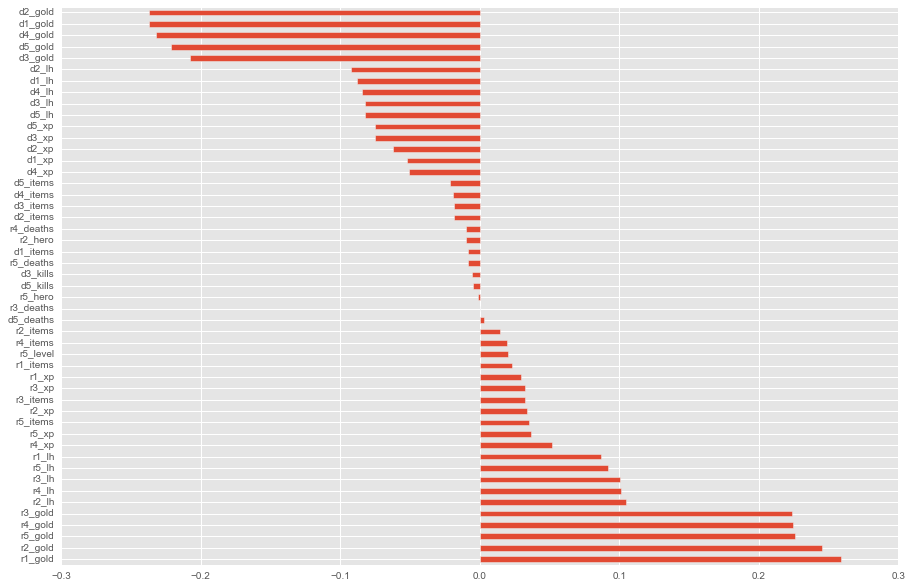

In [22]:
model_lr_explore_l1(data.get('train', 'players'), y).plot.barh(figsize=(15, 10))

У игроков сильнее всего на победу влияет количество золота. Следом идут убийства и опыт.

## Команда

Просуммировав признаки по игрокам видно, что соотношения остаются прежними: в топе золото, убийства и опыт.

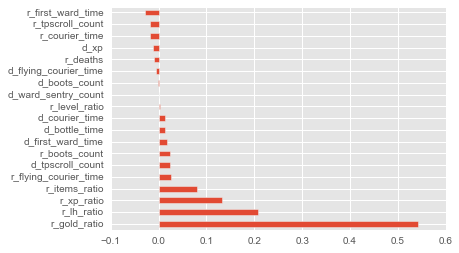

In [25]:
model_lr_explore_l1(data.get('train', 'teams'), y).plot.barh()

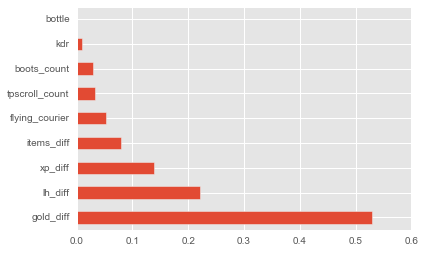

In [26]:
model_lr_explore_l1(data.get('train', 'team_diffs'), y).plot.barh()

In [125]:
df = pd.concat([y, data.get('train', 'team_diffs')], axis=1)

**Распределение и зависимость топовых признаков**:

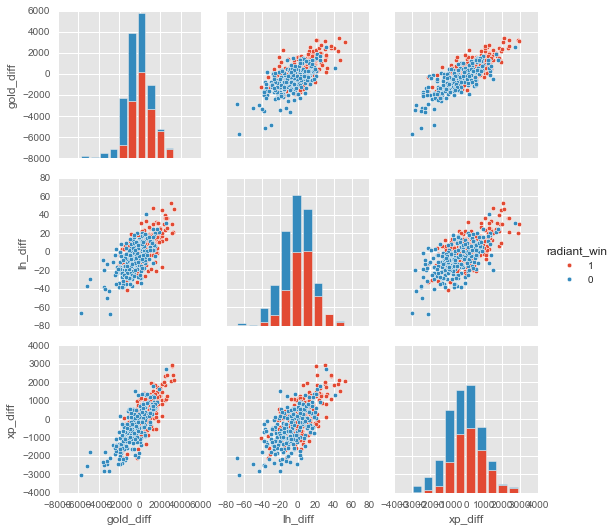

In [126]:
sns.pairplot(df.sample(500), vars=['gold_diff', 'lh_diff', 'xp_diff'], hue='radiant_win', hue_order=[1, 0])

### Покупка предметов в первые минуты

-1: Dire купили предмет, а Radiant нет  
0: Обе команды либо купили, либо не купили предмет  
1: Radiant купили предмет, а Dire нет

#### Количество случаев

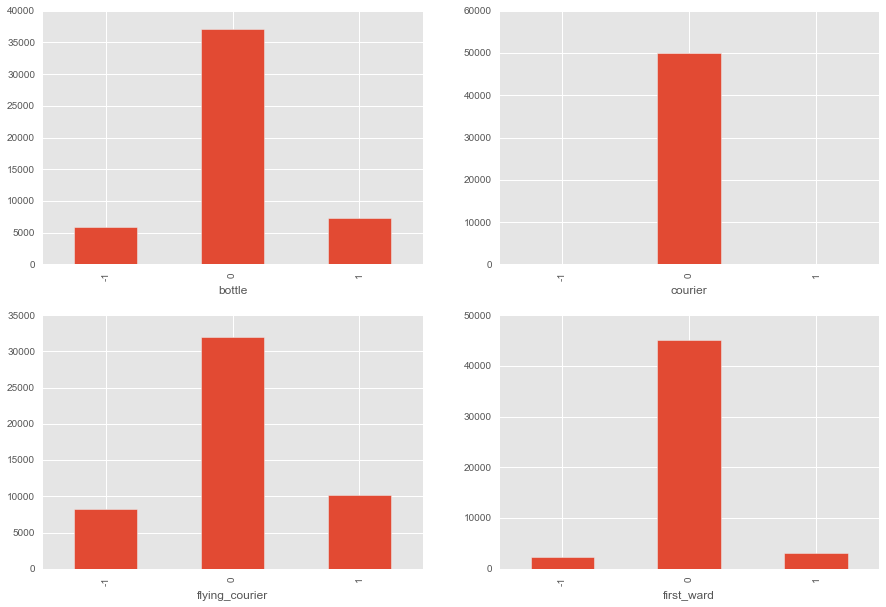

In [128]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, f in enumerate(['bottle', 'courier', 'flying_courier', 'first_ward']):
    df.groupby(f)['radiant_win'].sum().plot.bar(ax=axs[i // 2][i % 2])

#### Влияние на победу

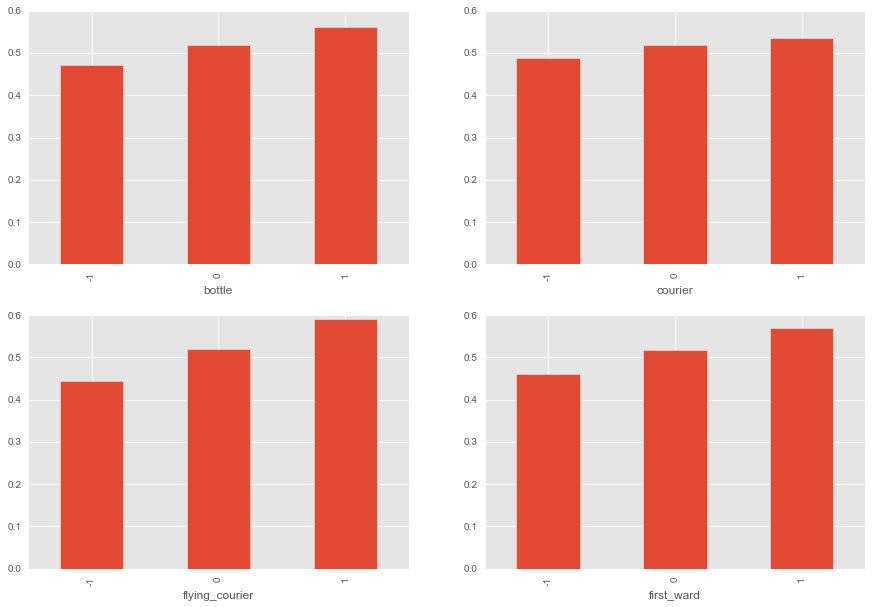

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, f in enumerate(['bottle', 'courier', 'flying_courier', 'first_ward']):
    df.groupby(f)['radiant_win'].mean().plot.bar(ax=axs[i // 2][i % 2])

Покупка любого из этих предметов в первые минуты игры положительно влияет на победу. Наибольшее количество случаев превосходства одной команды над другой у предметов bottle, flying_courier.

### Разница в предметах

In [25]:
data.load(10)
teams = data.get('train', 'teams')

df = pd.DataFrame()
df['boots'] = teams['r_boots_count'] - teams['d_boots_count']
df['tpscroll'] = teams['r_tpscroll_count'] - teams['d_tpscroll_count']
df['radiant_win'] = y

#### Boots

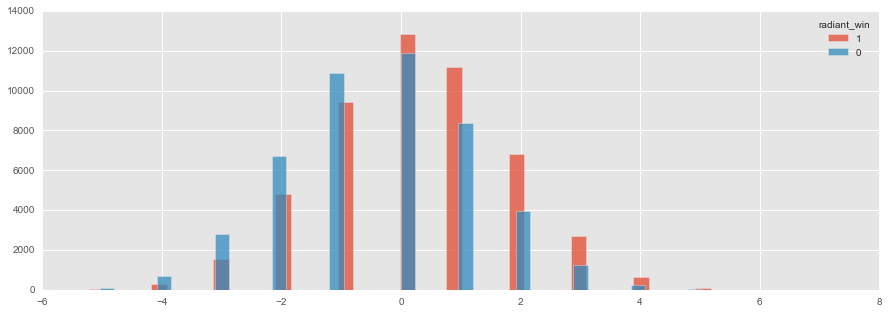

In [17]:
figsize(15, 5)
hist_by_radiant_win(df, 'boots')

Команды с большим количеством boots побеждают чаще. С увеличением разрыва шанс победы увеличивается.

#### TpScrolls

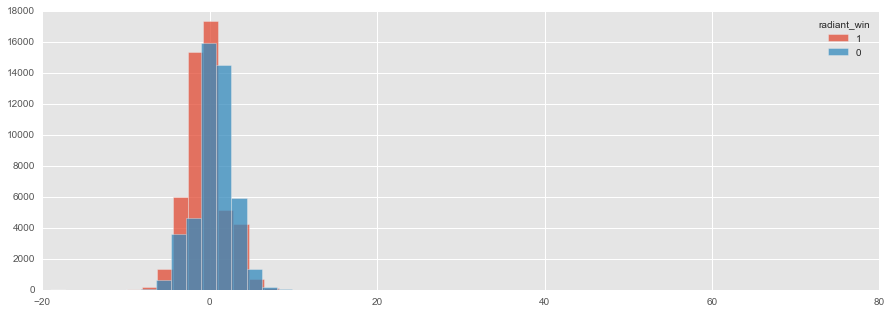

In [18]:
figsize(15, 5)
hist_by_radiant_win(df, 'tpscroll')

В разнице tpscroll есть выбросы - уберем их.

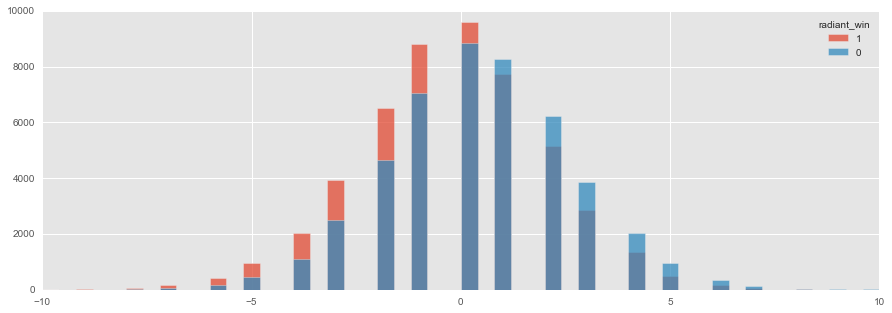

In [27]:
df['tpscroll'][df['tpscroll'] > 10] = 10
df['tpscroll'][df['tpscroll'] < -10] = -10

figsize(15, 5)
hist_by_radiant_win(df, 'tpscroll')

 Тут ситуация обратная. Команды с большим количеством tpscroll проигрывают чаще.

## Герои

In [2]:
heroes = data.get('train', 'heroes')
hero_weights = model_lr_explore_l1(heroes, y)

**Герои, которые положительно влияют  на победу:**

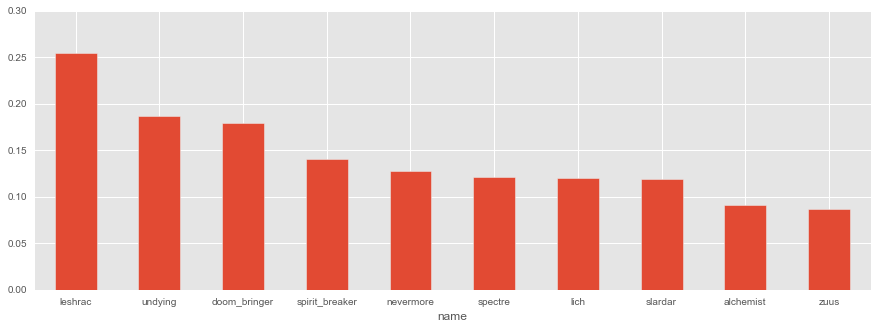

In [3]:
hero_weights.head(10).plot.bar(rot=0, figsize=(15, 5))

**Герои, которые отрицательно влияют на победу:**

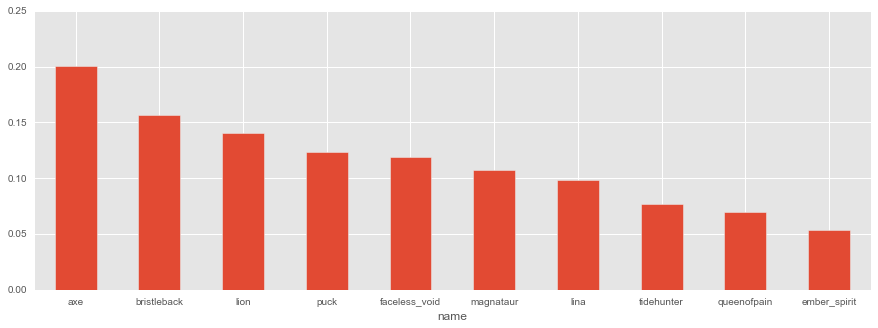

In [7]:
hero_weights.tail(10).abs()[::-1].plot.bar(rot=0, figsize=(15, 5))

# Новые фичи

In [31]:
data.load(33)

## Синергия / анти-синергия героев

In [32]:
synergy = data.get('train', 'synergy_matrix')
anti_synergy = data.get('train', 'anti_synergy_matrix')

### Синергия

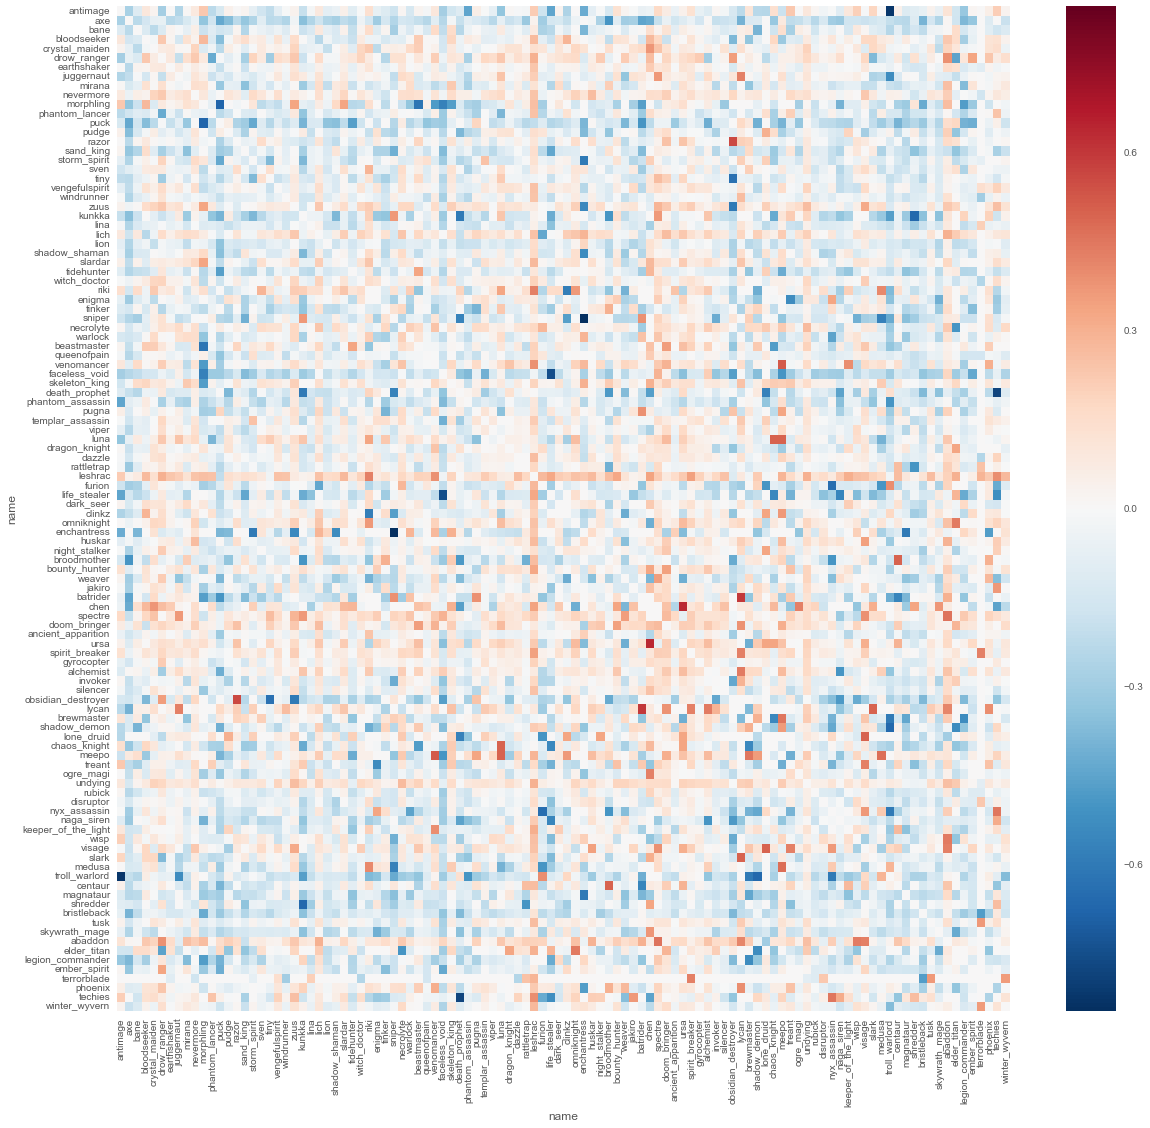

In [74]:
figsize(20, 18)
sns.heatmap(synergy)

### Анти-синергия

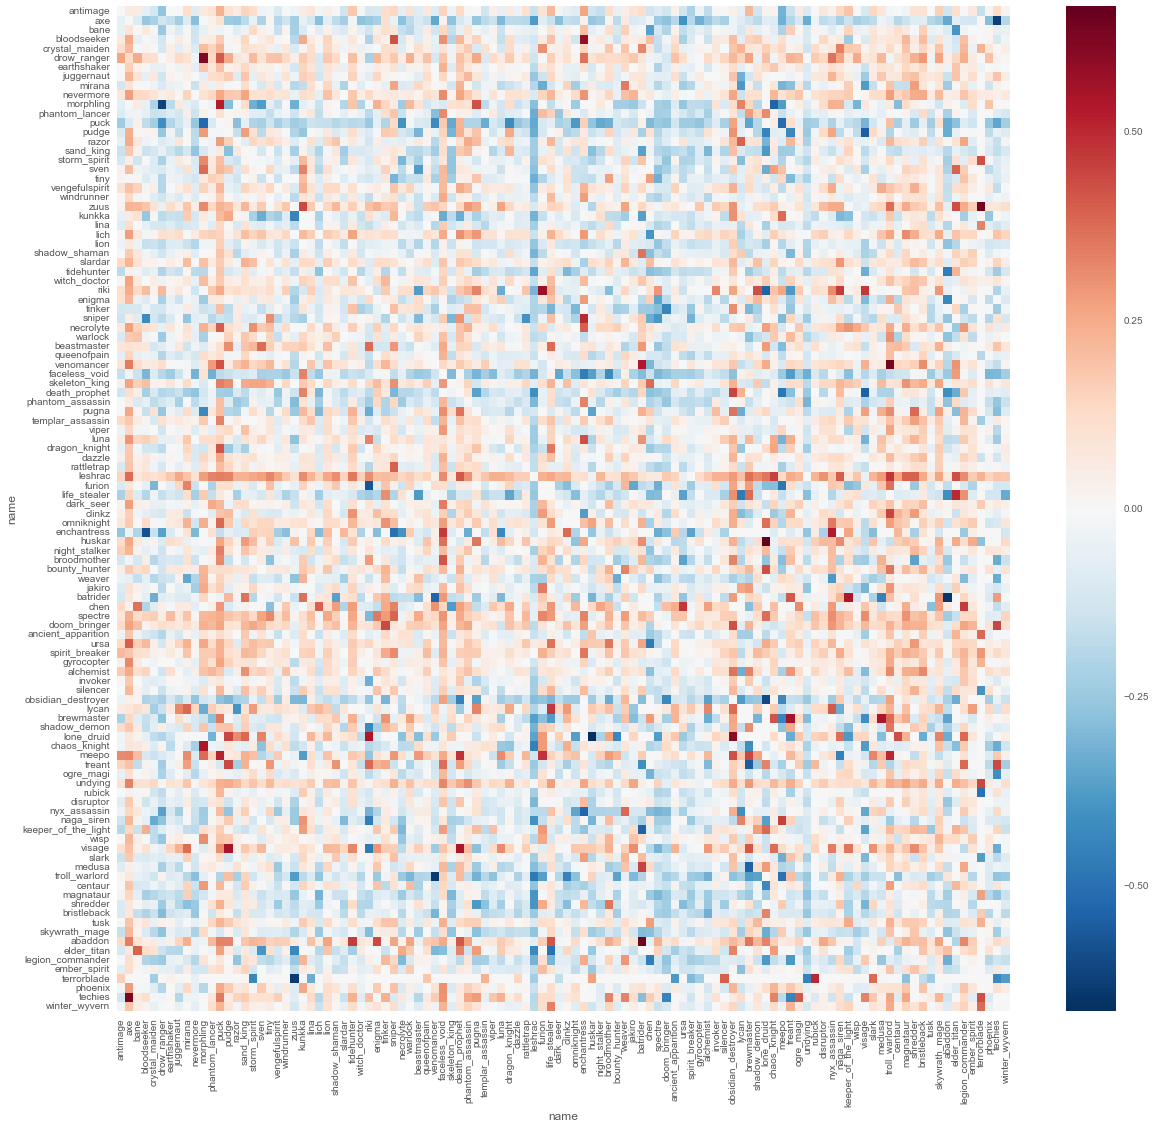

In [75]:
figsize(20, 18)
sns.heatmap(anti_synergy)

### Комбинации героев

In [3]:
def synergy_pair(h1, h2):
    return '{} + {}'.format(max(h1, h2), min(h1, h2))

def anti_synergy_pair(h1, h2):
    return '{} vs {}'.format(h1, h2)

def get_hero_pairs(matrix, pair_func):
    pairs = {}
    for h1, row in matrix.iterrows():
        for h2, val in row.iteritems():
            pairs[pair_func(h1, h2)] = val

    return pd.Series(pairs).sort_values(ascending=False)

synergy_pairs = get_hero_pairs(synergy, synergy_pair)
anti_synergy_pairs = get_hero_pairs(anti_synergy, anti_synergy_pair)

**Самые сильные комбинации:**  

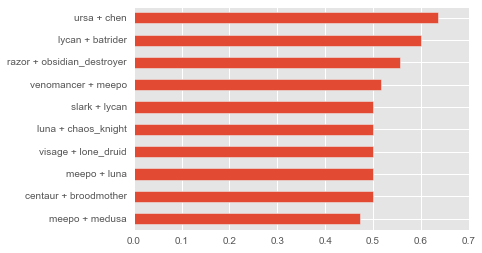

In [51]:
synergy_pairs.head(10).iloc[::-1].plot.barh()

**Самые слабые комбинации:**  

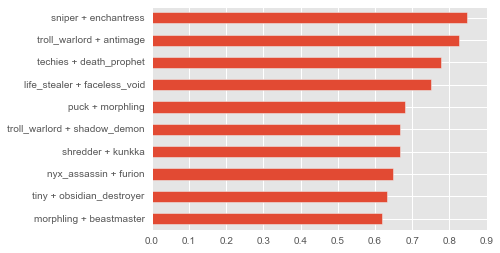

In [48]:
synergy_pairs.tail(10).abs().plot.barh()

**Контр-герои:** 

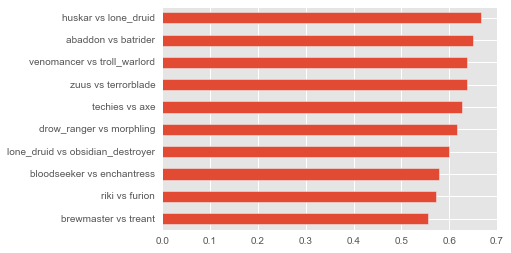

In [52]:
anti_synergy_pairs.head(10).iloc[::-1].plot.barh()

In [16]:
mean_anti_synergy = anti_synergy.mean(axis=1).sort_values(ascending=False)

**Наиболее универсальные герои**

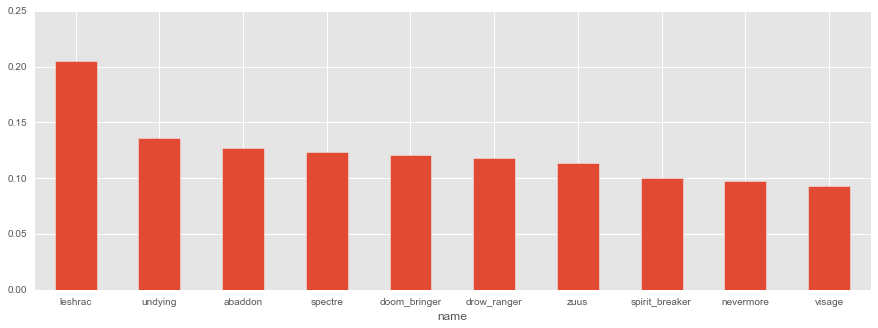

In [41]:
mean_anti_synergy.head(10).plot.bar(rot=0, figsize=(15, 5))

**Наименее универсальные герои**

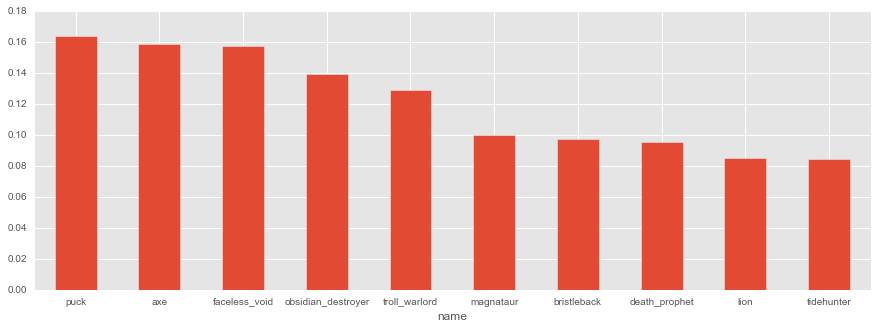

In [55]:
mean_anti_synergy.tail(10).abs().iloc[::-1].plot.bar(rot=0, figsize=(15, 5))

### Разница между командами в Синергия + Антисинергия

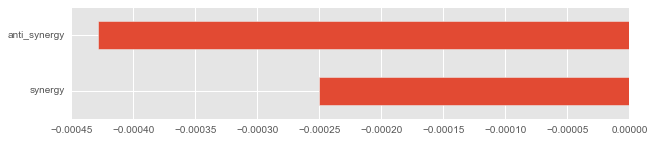

In [70]:
figsize(10, 2)
model_lr_explore_l1(data.get('train', 'synergy_sum'), y, C=1).plot.barh()

## Роли героев

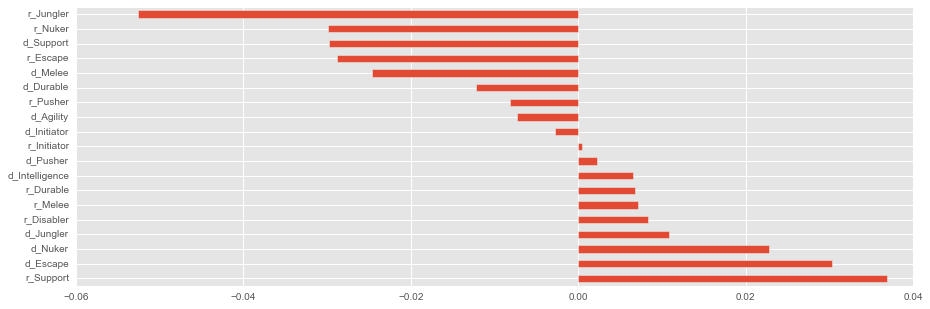

In [36]:
model_lr_explore_l1(data.get('train', 'hero_roles'), y).plot.barh()

### Перевес ролей в команде Radiant над командой Dire

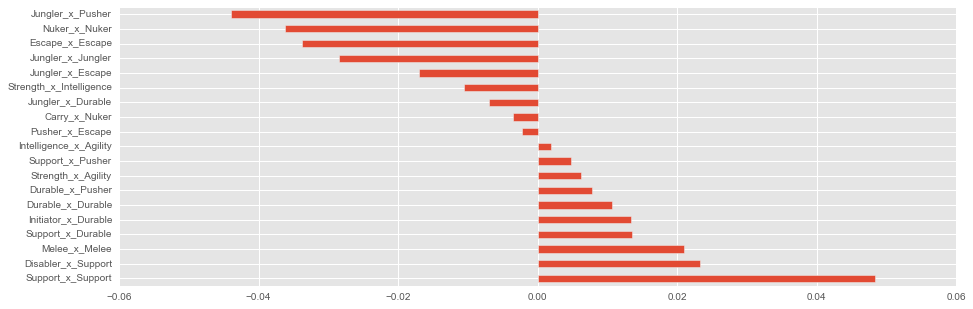

In [37]:
model_lr_explore_l1(data.get('train', 'hero_roles_bag'), y).plot.barh()

## Предметы

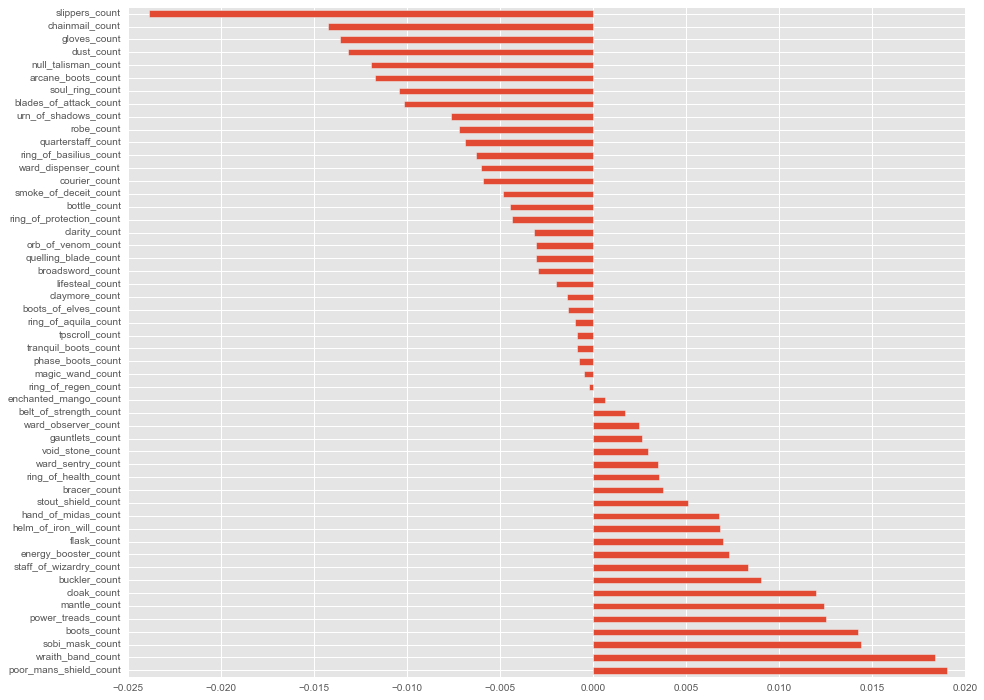

In [45]:
figsize(15, 12)
model_lr_explore_l1(data.get('train', 'items_diff'), y, C=0.1).plot.barh()

### Количественный перевес в предметах

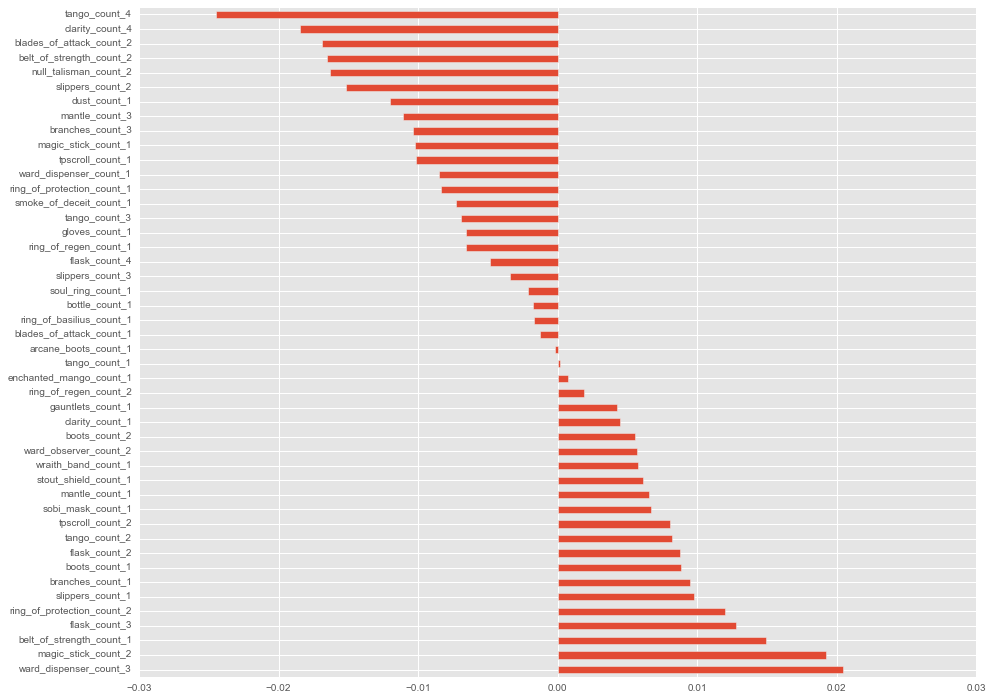

In [51]:
model_lr_explore_l1(data.get('train', 'item_counts'), y, C=0.03).plot.barh()

## Способности

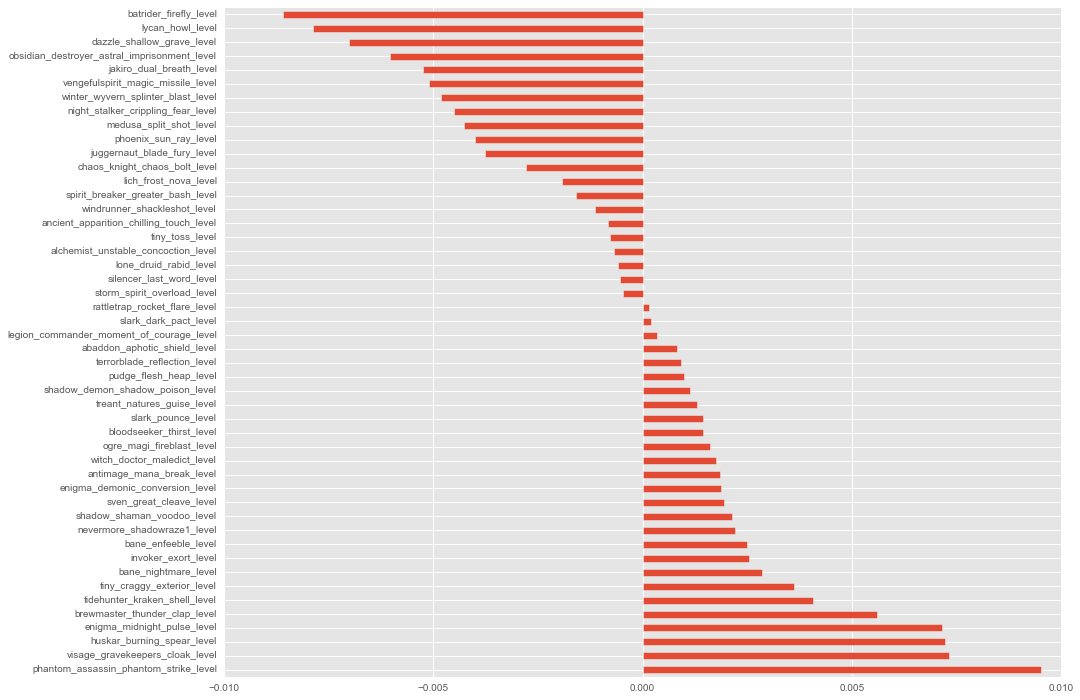

In [54]:
model_lr_explore_l1(data.get('train', 'abilities_diff'), y).plot.barh()

### Уровни способностей

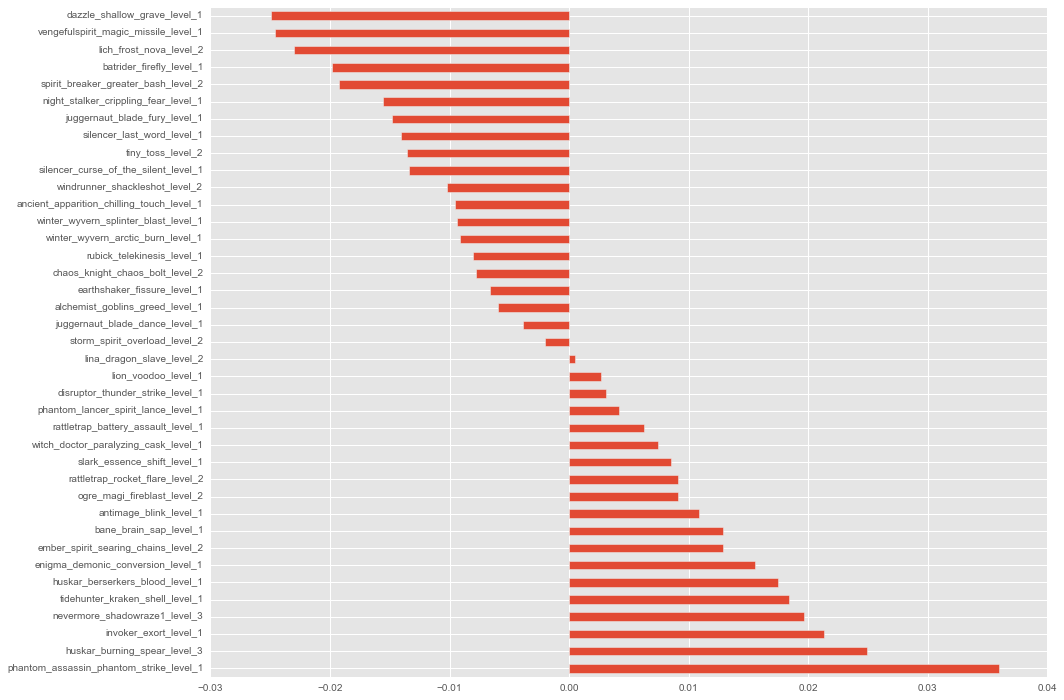

In [63]:
model_lr_explore_l1(data.get('train', 'ability_counts'), y, C=0.02).plot.barh()

## Разница в ресурсах между лучшими N игроками команд

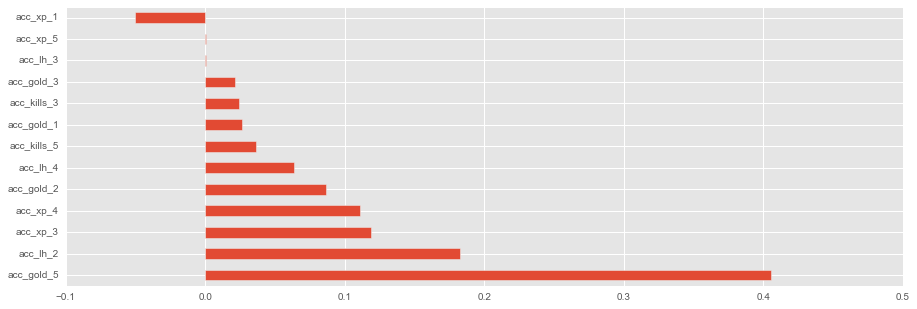

In [73]:
figsize(15, 5)
model_lr_explore_l1(data.get('train', 'team_accs'), y, C=0.01).plot.barh()

### Золото

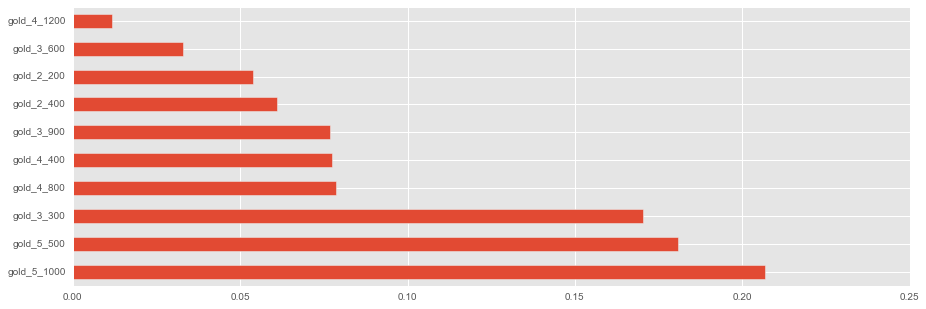

In [77]:
figsize(15, 5)
model_lr_explore_l1(data.get('train', 'gold_counts'), y, C=0.0005).plot.barh()

### Опыт

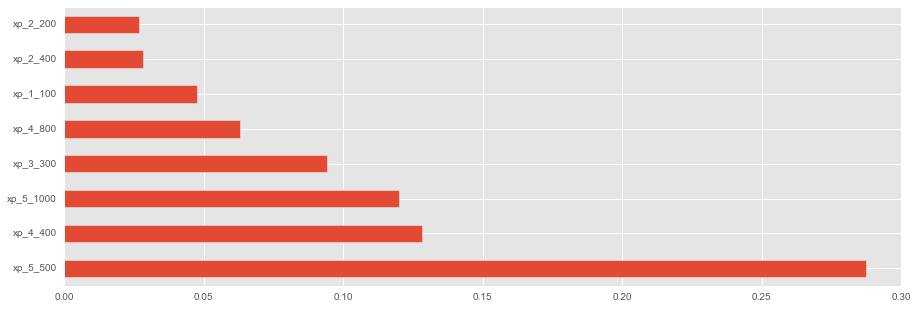

In [78]:
figsize(15, 5)
model_lr_explore_l1(data.get('train', 'xp_counts'), y, C=0.0005).plot.barh()

### Убийства

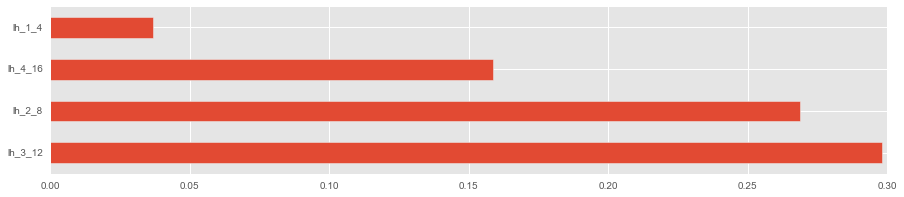

In [82]:
figsize(15, 3)
model_lr_explore_l1(data.get('train', 'lh_counts'), y, C=0.0005).plot.barh()

### Убийства героев

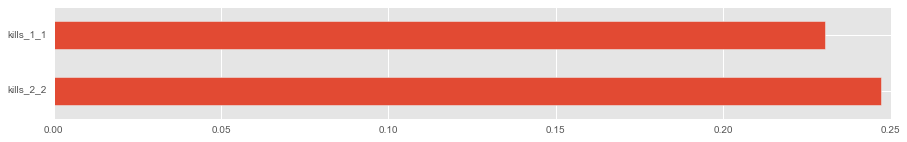

In [81]:
figsize(15, 2)
model_lr_explore_l1(data.get('train', 'kills_counts'), y, C=0.0005).plot.barh()

# Модель

In [2]:
data.load(29)

## Основная модель - LogisticRegression

In [3]:
X = data.extract('train', [
    ('match', ['lobby_type_practice']),
    ('models', ['time_xgb']),
    ('synergy_sum', None),
    ('item_counts', None),
    ('ability_counts', None),
    ('team_diffs', ['first_ward']),
    ('fb', ['first_blood_team']),
    ('gold_counts', None),
    ('xp_counts', None),
    ('lh_counts', None),
    ('kills_counts', None),
]).to_sparse(0)

scaler = skl.preprocessing.StandardScaler()
scale = ['time_xgb', 'anti_synergy', 'synergy']
X[scale] = scaler.fit_transform(X[scale])

model = skl.linear_model.LogisticRegression(random_state=1234, C=0.005)

### Кросс-валидация

In [4]:
cv = skl.cross_validation.KFold(len(y), n_folds=10, shuffle=True, random_state=42)
scores = skl.cross_validation.cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=2, verbose=True)

print(scores)
print(scores.mean())

[ 0.75575295  0.75790839  0.75841436  0.75989702  0.74913216  0.75964229
  0.76893036  0.75922596  0.76011089  0.75858803]
0.758760240976


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   54.9s finished


### Коэффициенты

In [20]:
model.fit(X, y)
c = pd.Series(model.coef_[0], index=X.columns).sort_values()

**Положительные:**

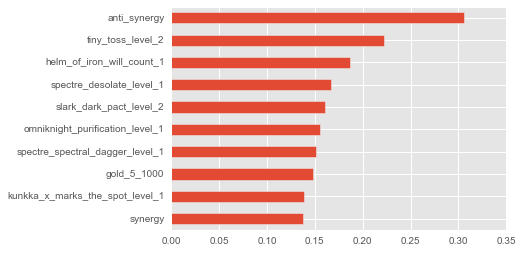

In [21]:
c.tail(10).plot.barh()

**Отрицательные:**

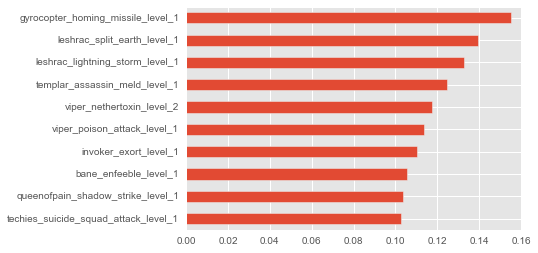

In [24]:
c.head(10).iloc[::-1].abs().plot.barh()

### Результат на лидборде

Полученный результат 0.763 разошелся с результатами кросс-валидации в 0.758. В дальнейшем это отставание в 0.005  сохранилось. Видимо есть расхождения в балансе обучающего и тестового сетов.

## Итог

Кроме основной модели у меня также было 4 менее удачных, но объединение этих 5 моделей дало результат на лидборде в  0.764. Еще немного улучшить результат можно за счет тренировки моделей по конкретным типам комнат и усреднение их результата с предыдущей, основной прирост вышел за счет lobby_type_practice. Итоговый результат - 0.76477, 13 место.